# Documentation
<br>
This notebook is the second step in a Bayesian workflow that deals with Bradford Protein Quantification 96x well plate reader data:

1. Imports parsed data for both calibrant and sample data from the first notebook (bradforddataprocessing_rawdata_parser.ipynb) from the directory processed_data_files.

2. Defines flat priors
3. Sets up the linear model using pymc3
4. Exports the model object as a .data file using pickle
5. Fits the model using MCMC variant NUTS
6. Explores the nature and quality of the parameter posteriors
7. Converts the Inference Object into an arviz InferenceData Xarray object so it is easier to work with.
8. Writes the arviz InferenceData Xarray to disk as a NETCDF .nc file


Alex Perkins 16th November 2021
a.j.p.perkins@sms.ed.ac.uk

In [1]:
save_figures_toggle=1

### Environment Preparation ---------------------------------------------------------------

### Import Packages

In [2]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample

print(f"Running on PyMC3 v{pm.__version__}")

import arviz as az
import xarray as xr
from scipy.stats import norm

# Import curve fitting package from scipy
from sklearn.linear_model import LinearRegression

# import os
import os, sys, shutil

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.4


### End of Enviroment Setup ---------------------------------------------------------------------------

In [3]:
#  define limits for linear range of platereader
upper_limit = 0.75
lower_limit = 0.45


# Data Import

### This cell checks that processed_data_files exists.

In [4]:
# define error handler
class DirectoryError(Exception):   
    def __init__(self, data):    
        self.data = data
    def __str__(self):
        return repr(self.data)

    
    
# home the HEAD for neatness
os.chdir('/src/')

print('Current working directory: '+str(os.getcwd()))

print('Checking if the directory: processed_data_files exists... ')


path = "/src/processed_data_files/"

try:
    os.chdir(path)
        
    print('It does!')
    print('Current working directory: '+str(os.getcwd()))
        
except:
    print()
    raise DirectoryError(path+' does not exist. Run: bradforddataprocessing_rawdata_parser.ipynb first to parse the raw data..');
    print(e.data)
    # kills the process
    quit()


Current working directory: /src
Checking if the directory: processed_data_files exists... 
It does!
Current working directory: /src/processed_data_files


### This cell deals with reading in the data files in the directory processed_data_files

In [5]:
# gets all items in directory
items = os.listdir(".")

# lists all .csv and puts them in a list.
csv_list = []
for names in items:
    if names.endswith(".csv"):
        csv_list.append(names)

print('CSV files identified: ' + str(csv_list))

##########################################################################################

#import calibrant dataset as dataframe
calibrants_for_GP = pd.read_csv(csv_list[csv_list.index('parsed_calibrant_data.csv')], header=0, index_col=0)
#import sample dataset as dataframe
acceptable_data = pd.read_csv(csv_list[csv_list.index('parsed_sample_data.csv')], header=0, index_col=0)

CSV files identified: ['parsed_calibrant_data.csv', 'parsed_sample_data.csv']


# Gaussian Process Linear Regression
Now we can easily sample our gaussians. Let's perform a linear regression to produce our standard curve.

Simple linear regression:

$$ y_i = \beta_1 x_i + \beta_0  + \epsilon_i $$

All that's happening here is:

$$ y_i = m x_i + c $$

Except that we define the model parameters as distributions.


## Defining the Prior Distributions

There are three unknowns, each of which need to be given a prior. Let's first deal with *m* & *c*:

Let's give them uniform priors to encapsulate that we know little about what they should be.

### Slope

The minimum slope must be 0.
The maximum: 10000

$$\beta_0 \in [0, 10000]$$

### Intercept

The minimum intercept:-100.
The maximum: 20

$$\beta_0 \in [-100, 20]$$




So Ɛ is the error constant and it's defined by a Normal distribution that is parameterised by mean of 0 and a standard deviation of a half Normal. Why? Because an error can be theoretically zero but never negative. Hence it can only vary in the positive direction.

$$ \epsilon_i \sim N(0, \sigma) $$

$$\sigma \sim \text{HalfNormal}(50)$$

I'm going to plot out these prior distributions below so it is more intuitive.


In [6]:
initalise_prior_mean_slope =  250
initalise_prior_sigma_slope = 100

initalise_prior_mean_intercept = -50
initalise_prior_sigma_intercept = 100

initalise_prior_sigma_error = 50


/src/processed_data_files


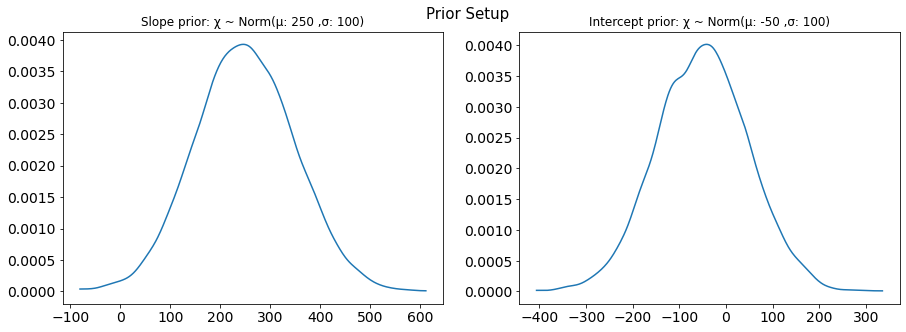

In [7]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

fig.suptitle('Prior Setup', fontsize=15, y=0.95)
fig.subplots_adjust(hspace=20)
    

sample_size = 1000
bins_size = int(sample_size/10)

##### Slope data

β1_normal_distribution = pm.Normal.dist(mu=initalise_prior_mean_slope, sigma = initalise_prior_sigma_slope)
β1_data= β1_normal_distribution.random(size=10000)

#### intercept data

β0_normal_distribution = pm.Normal.dist(mu=initalise_prior_mean_intercept, sigma = initalise_prior_sigma_intercept)
β0_data= β0_normal_distribution.random(size=10000)

# plotting lists
prior_data = [β1_data, β0_data]
prior_titles = ['Slope prior: χ ~ Norm(μ: '+str(initalise_prior_mean_slope)+' ,σ: '+str(initalise_prior_sigma_slope)+')', 'Intercept prior: χ ~ Norm(μ: '+str(initalise_prior_mean_intercept)+' ,σ: '+str(initalise_prior_sigma_intercept)+')']

##   plotting
for data, title, ax in zip(prior_data, prior_titles, axs.ravel()):
    az.plot_kde(data, ax=ax)  
    ax.set_title(title)


if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    plt.savefig('Prior_Distributions.png')
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
fig.show()


### So now having a look at the Ɛ prior setup

/src/processed_data_files


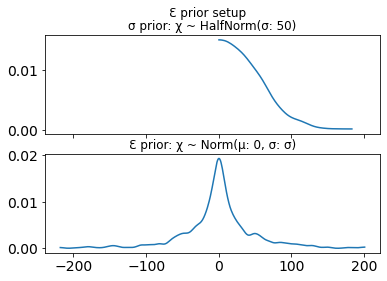

In [8]:
fig, axs = plt.subplots(2,1, sharex=True)
fig.suptitle('Ɛ prior setup')

## so, the way it should be done according to the equations. i.e. half normally distributed std of errors

σ_half_normal_distribution = pm.HalfNormal.dist(sigma=initalise_prior_sigma_error)
σ_data = σ_half_normal_distribution.random(size=sample_size)



Ɛ_normal_distribution = pm.Normal.dist(mu=0, sigma = σ_data)
Ɛ_data= Ɛ_normal_distribution.random(size=sample_size)

# plotting lists
error_prior_data = [σ_data, Ɛ_data]
error_prior_titles = ['σ prior: χ ~ HalfNorm(σ: '+str(initalise_prior_sigma_error)+')', 'Ɛ prior: χ ~ Norm(μ: 0, σ: σ)']

##   plotting
for data, title, ax in zip(error_prior_data, error_prior_titles, axs.ravel()):
    az.plot_kde(data, ax=ax)  
    ax.set_title(title)


if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    plt.savefig('Error Prior_Distributions.png')
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
fig.show()


Hang on a second... the Ɛ Prior has negative values?!

### Packaging data into PyMC3 data object

In [9]:
# The data has two dimensions: Sample# and Type
coords = {"Sample#": calibrants_for_GP.index, "Type": calibrants_for_GP.columns}

### Extract data for regression

In [10]:
x,y = calibrants_for_GP[['Absorbance', 'Concentration']].values.T

### Define model with PyMC3

<br>
Note to self: this is the explainer that I wish that I'd found days and bleeding NIGHTS ago:
<br>
https://towardsdatascience.com/bayesian-linear-regression-in-python-via-pymc3-ab8c2c498211



In [50]:
with pm.Model(coords=coords) as linear_standard_curve_model:


    #defining priors
    β_0 = pm.distributions.continuous.Uniform(name='intercept',lower=-100, upper=100)
    β_1 = pm.distributions.continuous.Uniform(name='slope',lower=0, upper=300)
    σ = pm.HalfNormal('error', sigma=1)
    
    # this is the data container where we store our concentrations - not for changing
    y_ = pm.Data('Concs_observed', y)
    # this is a changable data container for initally the training data followed by new predictions later on
    x_ = pm.Data('Absorbances', x)

    
    #defining model
    μ = β_0 + β_1 * x_
    
    # defining likelihood
    concentrations = pm.Normal('Concentrations', mu=μ, sigma = σ, observed=y_)

## Pickling the model
Now that we've defined the model and created it as a pm.model object, its being written to disk by pickle as a binary data stream .data file. This allows it to be accessible by other modules of the workflow downstream. God it took me time to workout how to do this.

In [51]:
import pickle
os.chdir('/src/processed_data_files/')
with open('linear_standard_curve_model.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(linear_standard_curve_model, filehandle)

### Looking at the model setup

In [52]:
linear_standard_curve_model.basic_RVs

#linear_standard_curve_model.free_RVs

#linear_standard_curve_model.observed_RVs

#linear_standard_curve_model.logp({"beta": 0})

[intercept_interval__ ~ TransformedDistribution,
 slope_interval__ ~ TransformedDistribution,
 error_log__ ~ TransformedDistribution,
 Concentrations ~ Normal]

### Do the inference using NUTS

The paper introducing the No-U-Turn-Sampler (NUTS).
http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf

As far as I can make out from forums, it's a self tuning, very efficient version of H-MCMC.
<br>

1. Sample the priors
2. Fit the model with NUTS
3. Sample the posteriors

In [53]:
with linear_standard_curve_model:
    
    #1
    prior = pm.sample_prior_predictive()
    #2
    linear_trace = pm.sample(1000, tune=5000, cores=3, step = pm.NUTS())
    #3
    posterior_predictions_concentrations = pm.sample_posterior_predictive(linear_trace, var_names=["slope", "intercept", "Concentrations"])
       


/tmp/ipykernel_983/3400674626.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  linear_trace = pm.sample(1000, tune=5000, cores=3, step = pm.NUTS())
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [error, slope, intercept]


Sampling 3 chains for 5_000 tune and 1_000 draw iterations (15_000 + 3_000 draws total) took 10 seconds.
There were 271 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5438978579268258, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### Move the inference object into an arviz InferenceData Xarray object  so it's much easier to work with

main resource: https://www.youtube.com/watch?v=bmWMdVQlzIA

In [54]:
with linear_standard_curve_model:
    protein_data = az.from_pymc3(trace=linear_trace, prior=prior, posterior_predictive = posterior_predictions_concentrations)

In [55]:
print(type(protein_data))
print(protein_data)

<class 'arviz.data.inference_data.InferenceData'>
Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data


### So let's have a look at the sampled posteriors

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


/src/processed_data_files


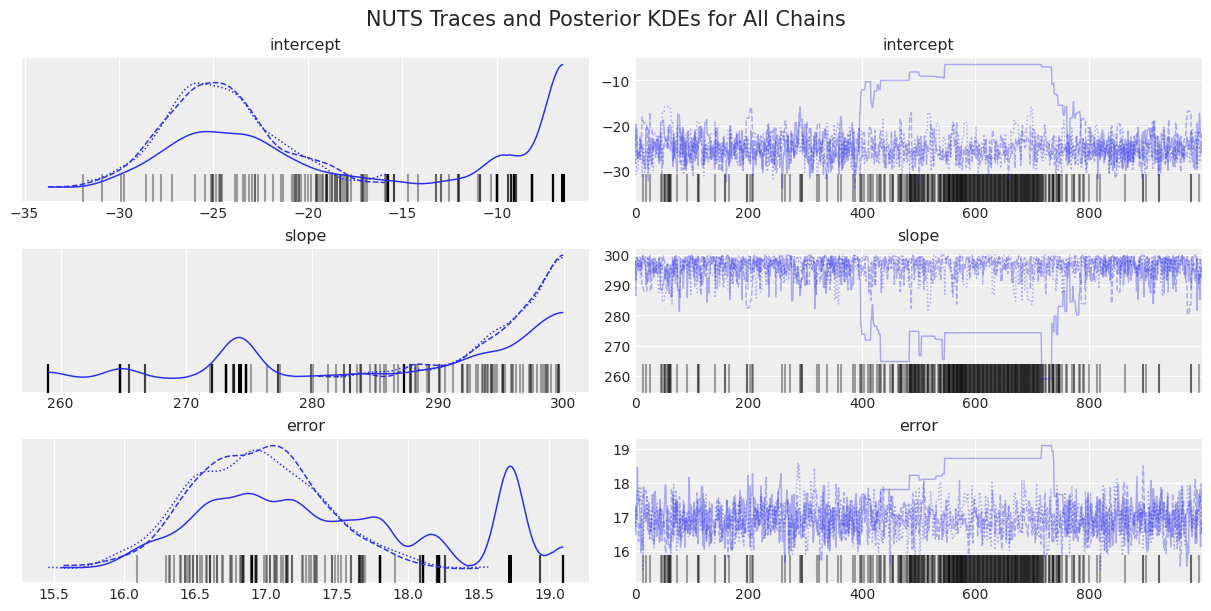

In [56]:

axes = az.plot_trace(linear_trace)
fig = axes.ravel()[0].figure
fig.suptitle('NUTS Traces and Posterior KDEs for All Chains', fontsize=15)

if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    fig.savefig('MCMC_traces.png')
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
fig.show()


## Comparing the Posteriors to the Priors
### Slope

/src/processed_data_files


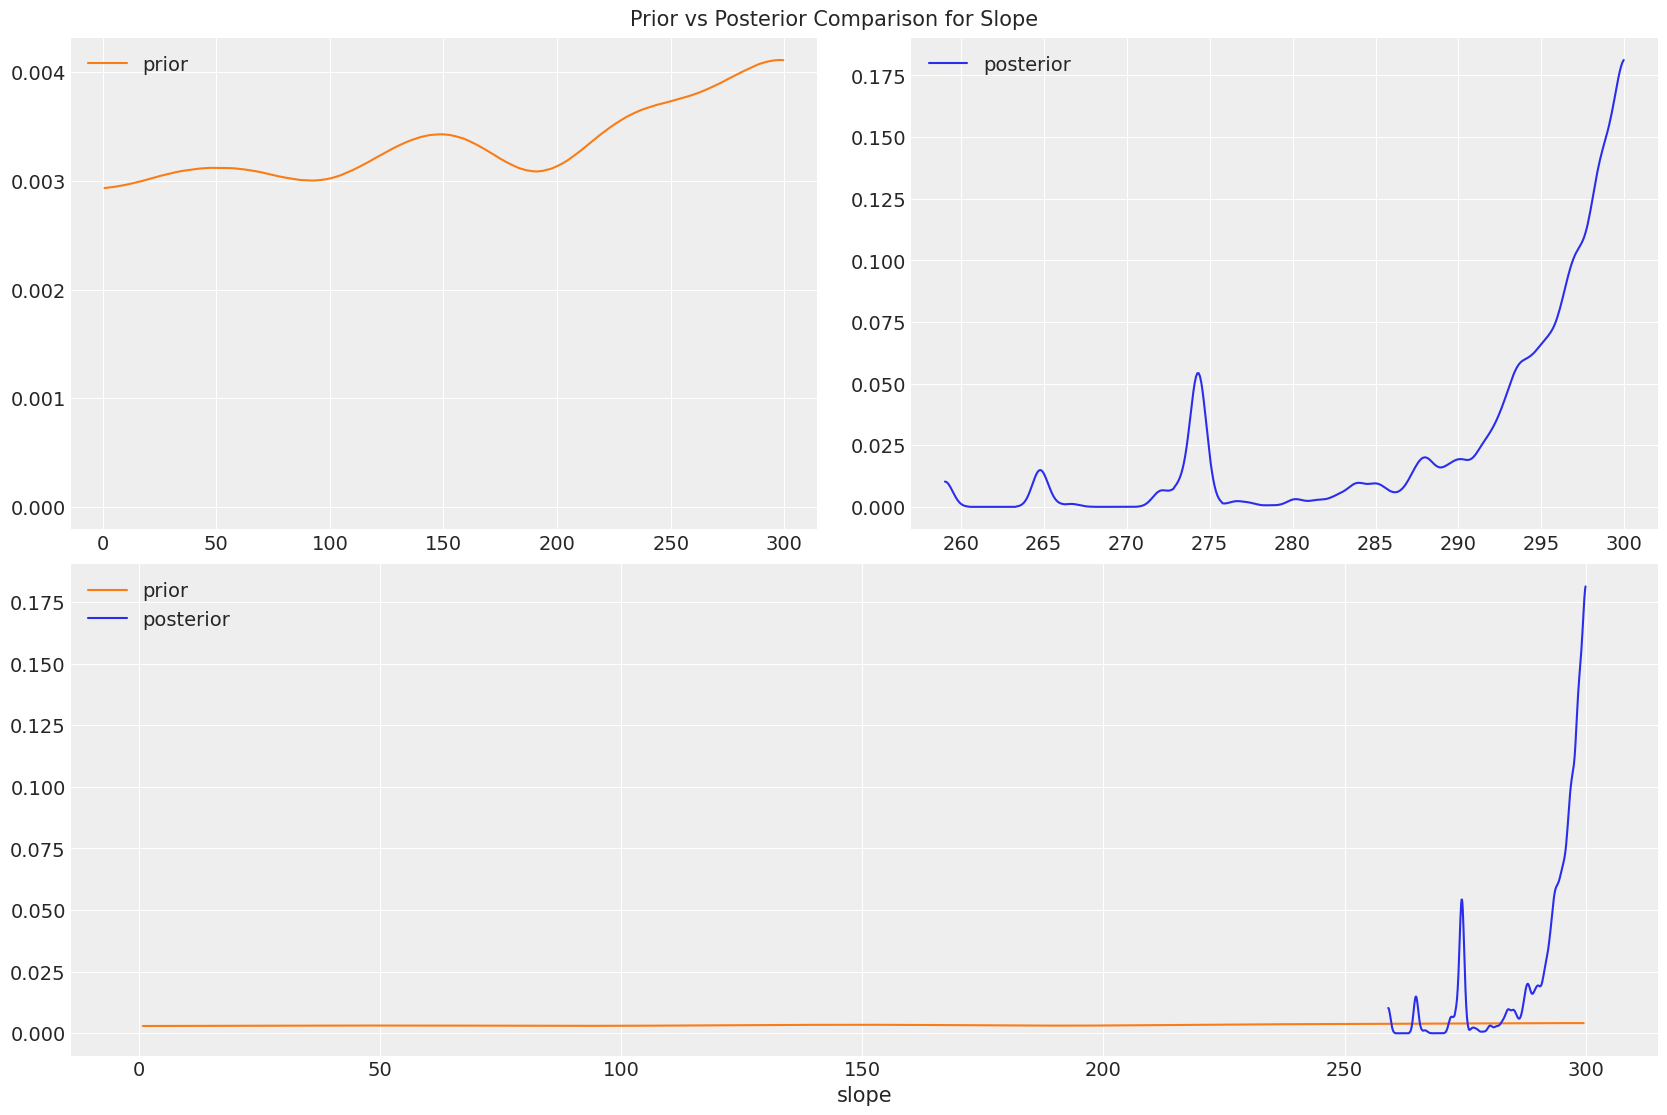

In [57]:
plot_parameter = "slope"

axes = az.plot_dist_comparison(protein_data, var_names=[plot_parameter])
fig = axes.ravel()[0].figure
fig.suptitle('Prior vs Posterior Comparison for ' +plot_parameter.capitalize(), fontsize=15)

if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    fig.savefig('Prior vs Posterior Comparison for ' +plot_parameter.capitalize()+'.png')
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
fig.show()



### Intercept

/src/processed_data_files


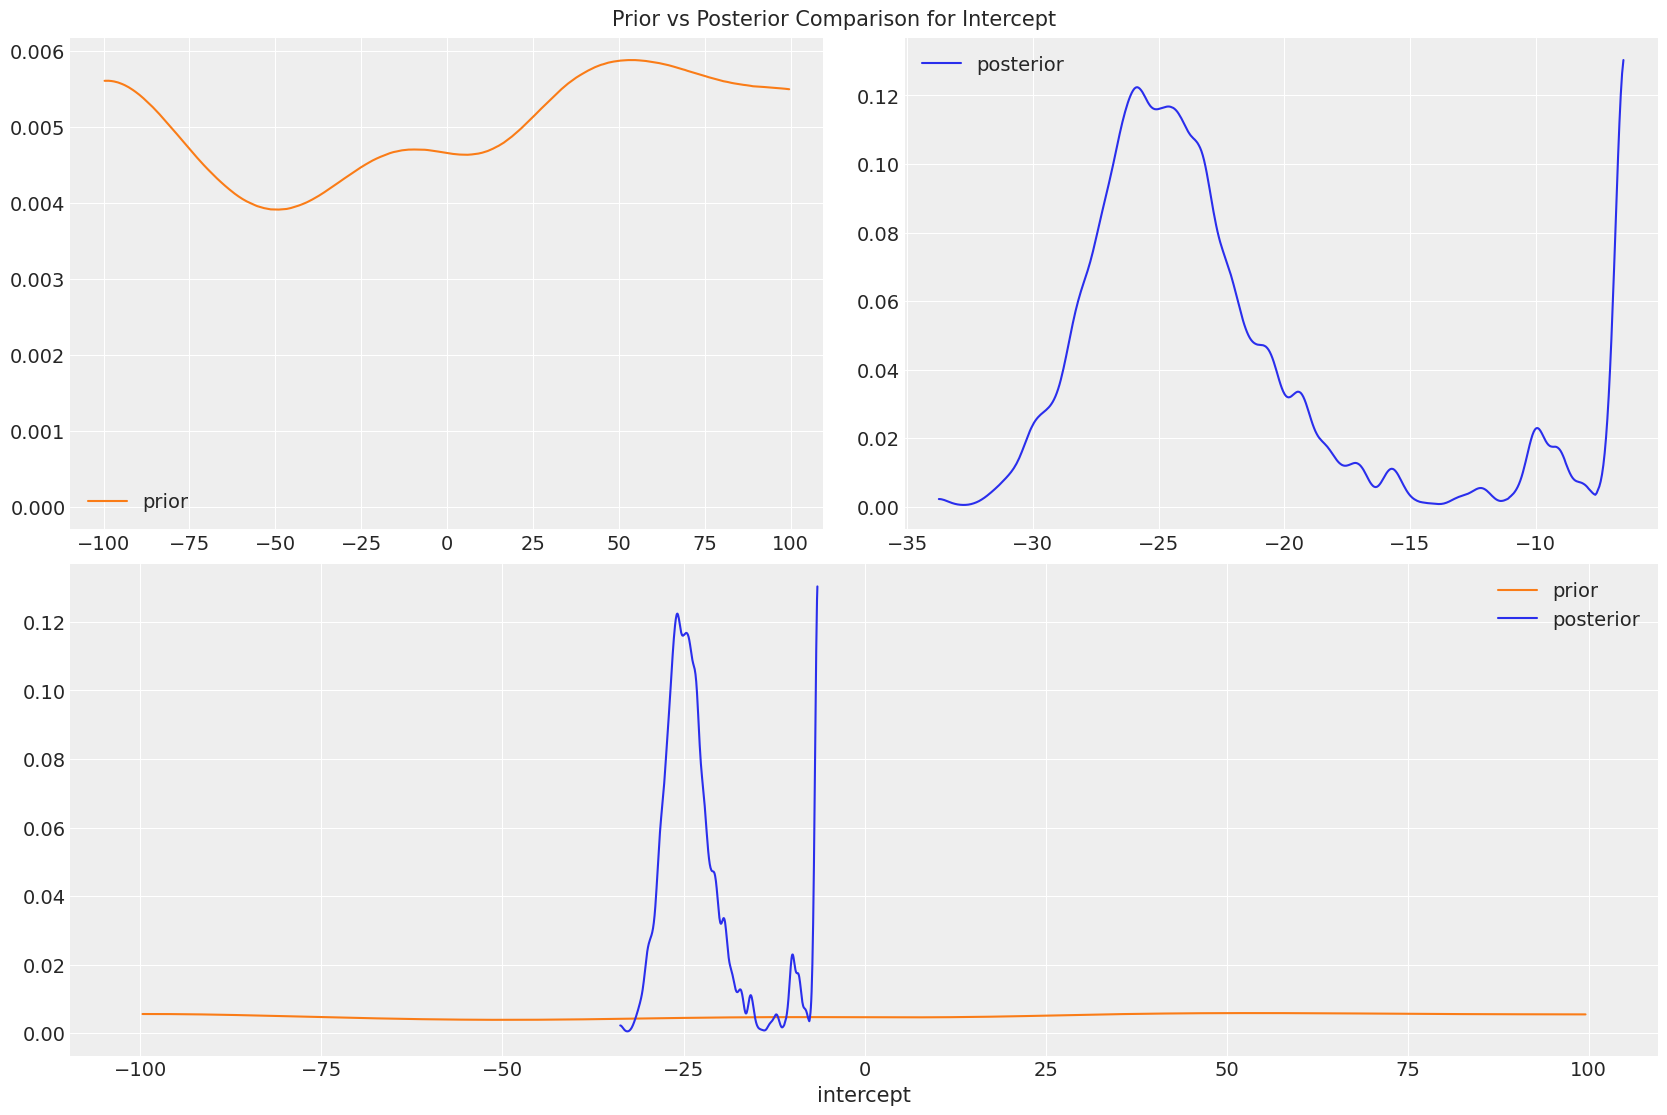

In [58]:
plot_parameter = "intercept"

axes = az.plot_dist_comparison(protein_data, var_names=[plot_parameter])
fig = axes.ravel()[0].figure
fig.suptitle('Prior vs Posterior Comparison for ' +plot_parameter.capitalize(), fontsize=15)

if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    fig.savefig('Prior vs Posterior Comparison for ' +plot_parameter.capitalize()+'.png')
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
fig.show()



## The Posteriors

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


/src/processed_data_files


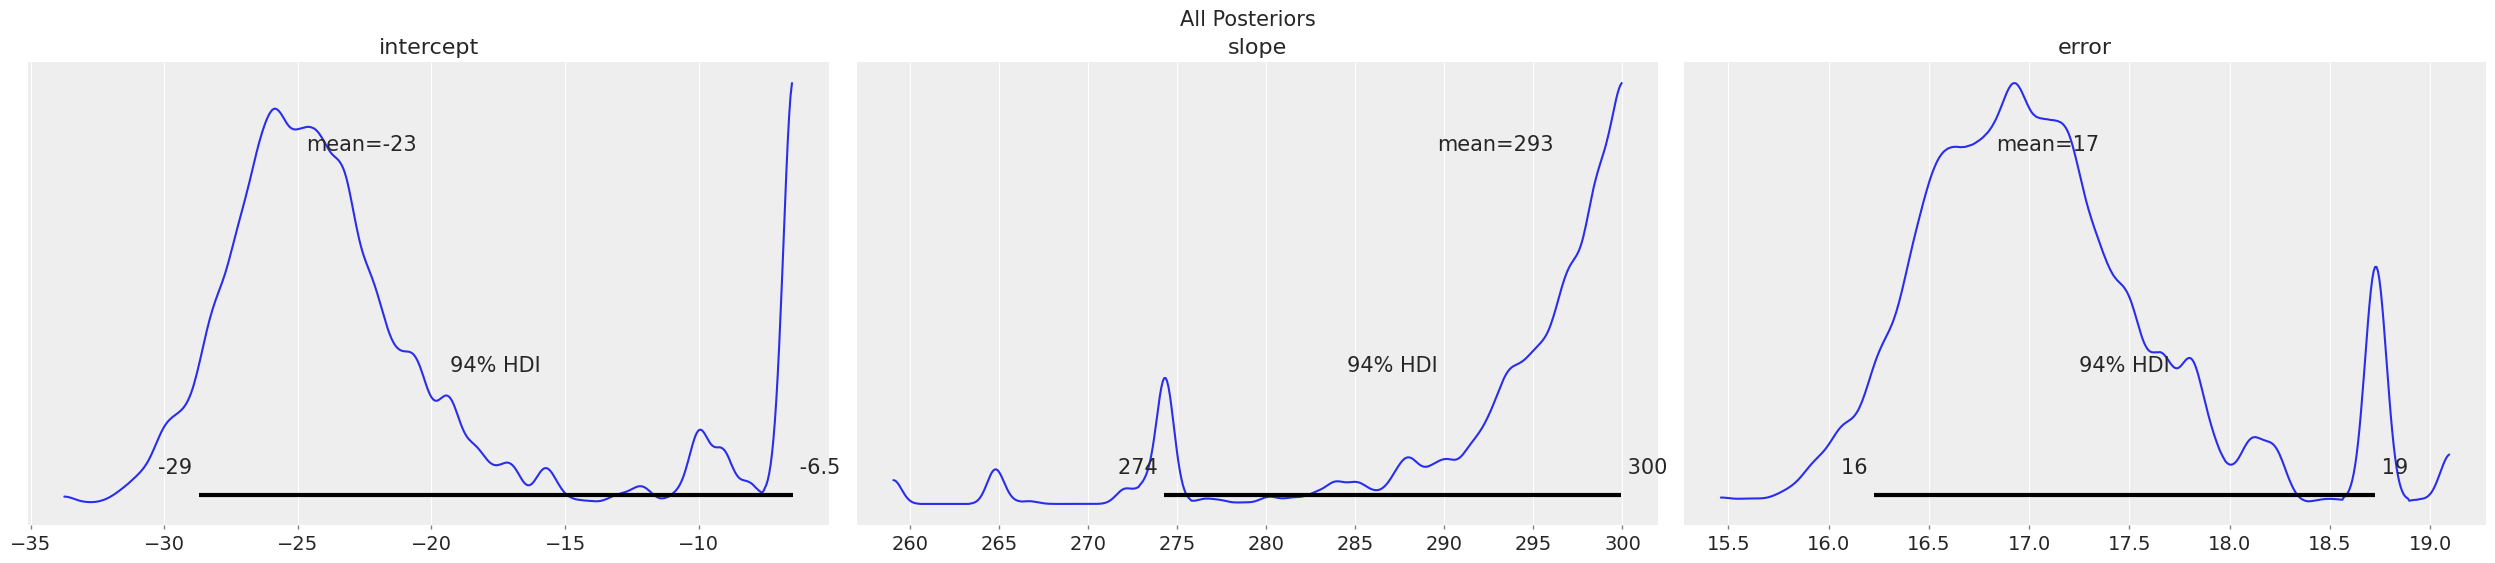

In [59]:


axes = az.plot_posterior(linear_trace)
fig = axes.ravel()[0].figure
fig.suptitle('All Posteriors', fontsize=15)

if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    fig.savefig('All Posteriors.png')
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
fig.show()


### Let's do some predictive checks

(3000, 59)
/src/processed_data_files


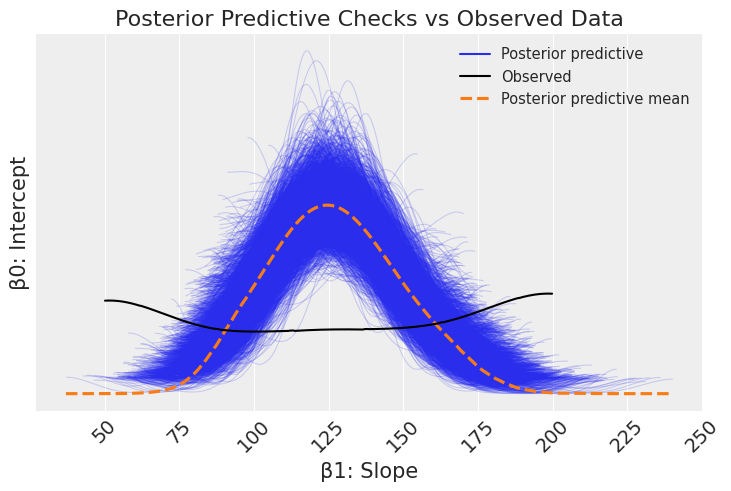

In [60]:
print(posterior_predictions_concentrations["Concentrations"].shape)

# Pair plot Baby!
az.style.use("arviz-darkgrid")

fig = az.plot_ppc(az.from_pymc3(posterior_predictive=posterior_predictions_concentrations, model=linear_standard_curve_model));

fig.set_ylabel('β0: Intercept')
fig.set_xlabel('β1: Slope')
fig.tick_params(axis='x', rotation=45)
fig.set_title('Posterior Predictive Checks vs Observed Data')

if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    plt.savefig('Posterior Predictive Checks vs Observed Data.png')
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
plt.show()

### Posterior Intercept vs Slope Pairplot

/src/processed_data_files


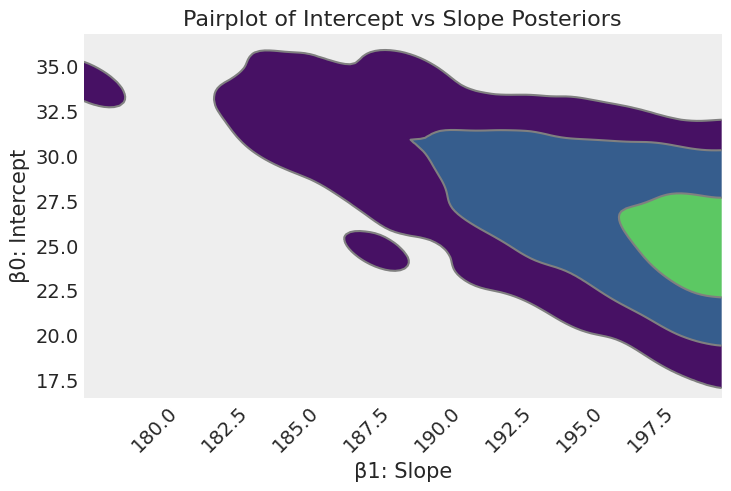

In [46]:
# extracting trace data from the 2D numpy array
beta_0_trace = linear_trace['intercept']
beta_1_trace = linear_trace['slope']


# Pair plot Baby!
az.style.use("arviz-darkgrid")

fig = az.plot_kde(beta_1_trace, beta_0_trace, hdi_probs=[0.393, 0.865, 0.989],  # 1, 2 and 3 sigma contours
#    contourf_kwargs={"cmap": "Blues"},
)

fig.set_ylabel('β0: Intercept')
fig.set_xlabel('β1: Slope')
fig.tick_params(axis='x', rotation=45)
fig.set_title('Pairplot of Intercept vs Slope Posteriors')

if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    plt.savefig('Pairplot of Intercept vs Slope Posteriors.png')
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
plt.show()


### Sampling candidate regression lines

Now that we have our sampled posteriors, we can use them to plot candidate regression lines.
I've only plotted some so you can see the distribution fade slightly

3000 = length of trace for the Betas
/src/processed_data_files


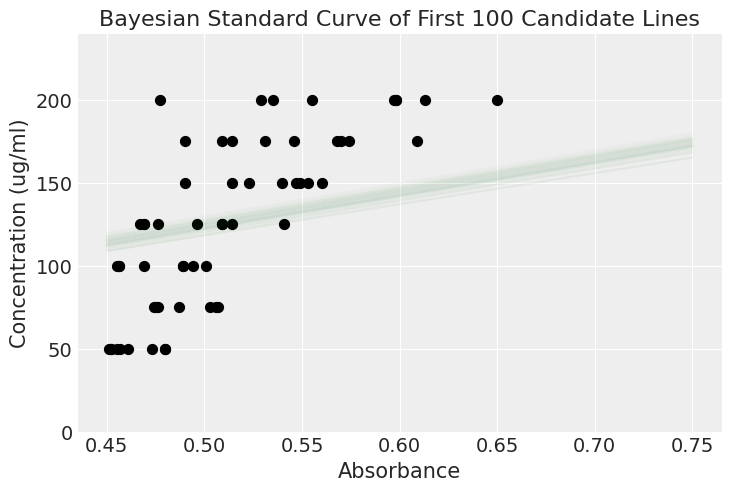

In [47]:
X_pred = np.linspace(lower_limit, upper_limit, 100)

ax = calibrants_for_GP.plot.scatter(x='Absorbance', y='Concentration', c='k', s=50)

#sets the ylim to the max y value plus 20%
ax.set_ylim(0, (y.max()+(y.max()/5)))

print(str(len(linear_trace['slope'])) + ' = length of trace for the Betas')

# so just sampling the first 100 of those data points in the posterior sample for the betas
plot_combined = np.column_stack((linear_trace['intercept'], linear_trace['slope']))

num_of_candidates =100

for intercept, slope in plot_combined[:num_of_candidates]:
    
    ax.plot(X_pred, intercept + slope*X_pred, alpha=0.008, color='seagreen');
    
ax.set_title('Bayesian Standard Curve of First '+str(num_of_candidates) + ' Candidate Lines')
ax.set_ylabel('Concentration (ug/ml)')



if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    plt.savefig('Bayesian Standard Curve of First '+str(num_of_candidates) + ' Candidate Lines.png')
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
plt.show()

## Plotting the error of the model

To estimate the errors, it is intractable to look at 100% of the posterior predicted density. So instead, a common method is to use the Highest Density Interval (HDI) which is the parameter limits within which 95% of the posterior probability density lies.

<br><br>

Another common method is the Equal Tailed Interval (ETI), a 95% ETI has 2.5% of the distribution on either side of its limits. It indicates the 2.5th percentile and the 97.5th percentile. The main benefit of the ETI is that it is easy to compute but ignores squewing. Hence for non-symetrical posteriors, HDI refers to the most probable (and therefore most credible) values. There is an illustration from a non-symetrical posterior below comparing the two.

<br><br>

If you look at the plot (**not the image in this cell**) below, the reason that the error is finite is because we are only plotting the 95% HDI.

<br><br>

<img src='img/HDI_example.png' width="400" height="400">

<br>

A great explainer: https://www.youtube.com/watch?v=JG69fxKzwt8

<br>

Ref: https://www.sciencedirect.com/topics/mathematics/highest-density-interval

/usr/local/lib/python3.8/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.8/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


/src/processed_data_files


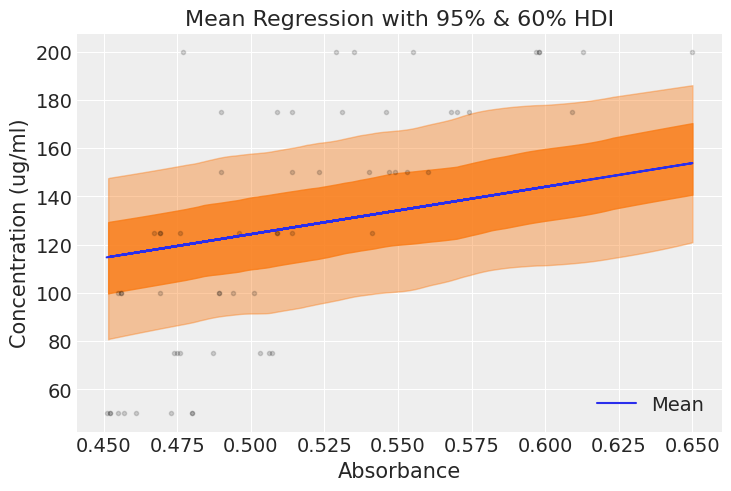

In [48]:

fig, ax = plt.subplots()

# Plotting the real data points

real_concs = calibrants_for_GP.Concentration
real_absorbances = calibrants_for_GP.Absorbance

ax.plot(real_absorbances, real_concs, "k.", alpha=0.15)

# plotting the Mean regression line: modelled_absorbances = c_mean + m_mean * real_concs

c_mean = linear_trace["intercept"].mean(axis=0)
m_mean = linear_trace["slope"].mean(axis=0)

ax.plot(real_absorbances, c_mean + m_mean * real_absorbances, label="Mean")


# lets plot the 60% HDI
az.plot_hdi(real_absorbances, posterior_predictions_concentrations["Concentrations"], hdi_prob=0.6, fill_kwargs={"alpha": 0.8})
# Plotting the 95% HDI
az.plot_hdi(real_absorbances, posterior_predictions_concentrations["Concentrations"], fill_kwargs={"alpha": 0.4})


plt.title('Mean Regression with 95% & 60% HDI')
plt.xlabel("Absorbance")
plt.ylabel("Concentration (ug/ml)");

plt.legend()

if save_figures_toggle == 1:
    
    os.chdir('/src/output/')
    plt.savefig('Mean Regression with 95% & 60% HDI.png')
    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    
plt.show()

# Optional Save to Disk

There is a bug somewhere that if this tries to overwrite the file that this kernal has already created **even if it has been deleted in the directory** then it'll throw a 'permission denied' error.
To fix this, shutdown the notebook in the jupyter directory.

In [49]:
if save_figures_toggle == 1:

    os.chdir('/src/processed_data_files/')
    print(os.getcwd())
    ret = os.access('/src/processed_data_files/', os.W_OK)
    print("W_OK - return value %s"% ret)
    
    
    az.to_netcdf(protein_data,'bradford_protein_data.nc')
    os.chdir('/src/')
    print(os.getcwd())


/src/processed_data_files
W_OK - return value True


PermissionError: [Errno 13] Permission denied: b'/src/processed_data_files/bradford_protein_data.nc'

### Notes for today

Tidy up - make notes:
1. Reorganise, clear out crap
2. Annotate and complete documentation.
3. Add coordinates.
4. Modularise workflow.
5. Save raw tracedata as separate Xarray to concensus concentrations
6. Readme & git commit

Optimise:
1. Define proper flat priors
2. Tune hyperparameters
3. Use for all the different datasets.

Corrie bartelheimer: https://www.youtube.com/watch?v=WbNmcvxRwow&t=1481s